# Housing Sales Prices & Venues Data Analysis of Lisbon

## Week 5 - Notebook

#### Exploring Lisbon Venues and House prices

* Build a dataframe of Lisbon neighbourhoods, with average house prices ranging from 2016 to 2019
* Build a geodataframe with neighbourhood areas, get neighbourhood coordinates and merge the dataframes
* Obtain Venue data for each neighbourhood using Foursquare API
* Explore and Cluster neighbourhoods based on its venues
* Relate Housing sales prices with exisitng venues per neighbourhood

### 1. Install and Import necessary libraries

In [8]:
#import libraries to read files from Watson Studio and scrape web data
import types
from botocore.client import Config
import ibm_boto3
import requests

#install and import the library to plot on maps
!conda install -c conda-forge folium
import folium
from folium import plugins

#import libraries to use pandas and arrays
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library

import matplotlib # plotting package
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
matplotlib.style.use(['ggplot'])

#import library to handle JSON files
import json


#tranform JSON file into a pandas dataframe and geo lookup
from pandas.io.json import json_normalize 
from geopy.geocoders import Nominatim 

#import k-means from clustering stage
from sklearn.cluster import KMeans

#install and import necessary libraries to use Geopandas
!conda install fiona pyproj six
!conda install geopandas
!conda upgrade --all
import geopandas as gpd

# import shapely to do the geometry comparisons
from shapely.geometry import shape, GeometryCollection, Point


print('libraries imported')

Solving environment: done

# All requested packages already installed.

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - fiona
    - pyproj
    - six


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geos-3.7.1                 |       he6710b0_0         1.6 MB
    click-plugins-1.1.1        |             py_0          11 KB
    xerces-c-3.2.2             |       h780794e_0         3.2 MB
    cligj-0.5.0                |           py36_0          12 KB
    gdal-2.3.3                 |   py36hbb2a789_0         1.3 MB
    kealib-1.4.7               |       hd0c454d_6         175 KB
    fiona-1.8.4                |   py36hc38cc03_0         1.0 MB
    libspatialite-4.3.0a       |      hb08deb6_19         3.1 MB
    pyproj-1.9.6               |   py36h14380d9_0          76 KB
    openjpeg-2.3.0             |       

### 2. Data Gathering and Cleaning

#### 2.1 Housing Prices in Lisbon



##### 2.1.1 Gathering Housing Prices for Portugal, Lisbon and each Lisbon neighbourhood

The csv file used in this step was downloaded from the Portuguese National Statistics Institute (INE) and imported to Watson Studio. The housing prices presented correspond to the price of m2.

In [6]:
def __iter__(self): return 0

@hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_4dc93ebff47c459eab879ec89a3076bf = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='btZ9k5EZI1dFzrZkFUM89pnmBjoiZHXNf-qiaGG-2gdm',
    ibm_auth_endpoint="https://iam.eu-gb.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_4dc93ebff47c459eab879ec89a3076bf.get_object(Bucket='courseracapstoneproject-donotdelete-pr-phxlvimss1j05c',Key='house_prices.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

#read csv and transform it to a dataframe    
df_data_1 = pd.read_csv(body, encoding='latin-1', delimiter=';')
df_data_1.head()

,Location,2019,2018,2017,2016
0,PT: Portugal,1011,950,881,830
1,1701106: Lisboa,3111,2581,2143,1875
2,170110601: Ajuda,3085,2259,1847,1535
3,170110602: Alcântara,2951,2271,1856,1512
4,170110654: Alvalade,3304,2957,2394,1979



##### 2.1.2 Data Cleaning of Housing Prices Dataframe

Looking at the original dataframe, we can see that we have some information in the "Location" column strings. We will remove the Location_ID since we won't need it. For our study we won't need also the first two rows since they those rows are not Lisbon neighbourhoods, so we'll also remove those rows. Finally, we'll add ", Lisboa" to the Location strings to guarantee that all locations retrieved correspond to Lisbon neighbourhoods.

In [7]:
#split the Location column into two columns: one with the location ID and other with Location Name
df_data_1[['Location_ID','NOME']] = df_data_1.Location.str.split(": ",expand=True) 

#remove Location_ID from the dataframe
df_data_1=df_data_1[['NOME','2016', '2017', '2018', '2019']]

#remove the first two rows since they are not Lisbon neighbourhoods (they correspond to Country and City Average)
df_data_2 = df_data_1.iloc[2:]

#make sure the column is type String
df_data_2['NOME']=df_data_2['NOME'].astype(str)
df_data_2['NOME']=df_data_2['NOME']+ ', Lisboa'
df_data_2.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,NOME,2016,2017,2018,2019
2,"Ajuda, Lisboa",1535,1847,2259,3085
3,"Alcântara, Lisboa",1512,1856,2271,2951
4,"Alvalade, Lisboa",1979,2394,2957,3304
5,"Areeiro, Lisboa",1803,2193,2550,3019
6,"Arroios, Lisboa",1763,1997,2587,3194


##### 2.1.3 Housing Price Growth

Let's do a quick analysis of the evolution in housing prices to see if we can really say that there was a touristic *boom*, and somewhat of housing "bubble", driving prices through the roof in Lisbon.

Text(0.5, 1.0, 'Rate of Housing Price Growth 2016-2019 (%)')

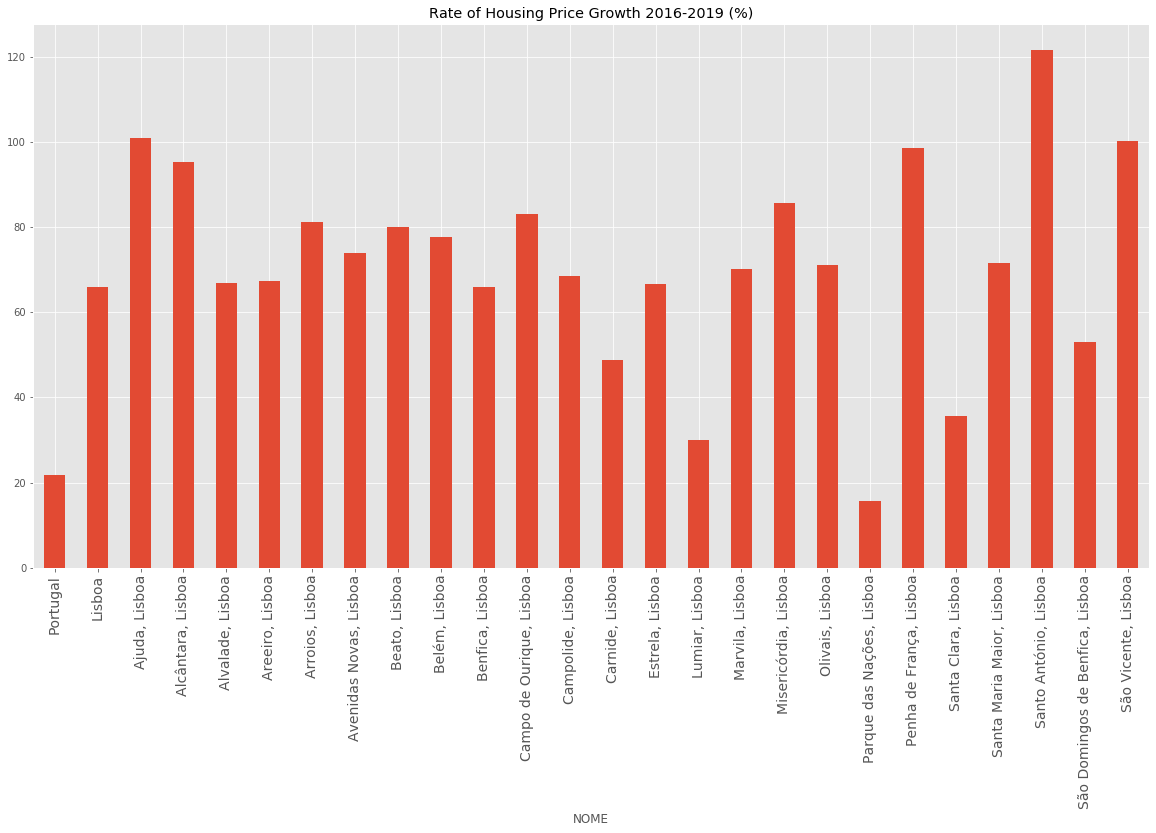

In [99]:
df_data_1=df_data_1.set_index('NOME')

#calculate rate of growth between 2016 and 2019 in %
df_data_1['Rate']=((df_data_1['2019']-df_data_1['2016'])/df_data_1['2016'])*100

#plot the data
df_data_1=df_data_1['Rate']
df_data_1.plot.bar(rot=0,figsize=(20, 10))
plt.xticks(fontsize=14, rotation=90)
plt.title('Rate of Housing Price Growth 2016-2019 (%)')

We can see that prices in Lisbon grew the triple when comparing to the whole country. While housing prices in Portugal grew only 20% in the last 4 years, in Lisbon we can observe a growth over 60%.

#### 2.2 Geographic data of Lisbon neighbourhoods



##### 2.2.1 Gathering Geographic data of Lisbon neighbourhoods

The Geojson file used to retrieve information was provided by the Lisbon City Hall Open Data Programme. We'll retrieve the data directly from the website.

In [16]:
#scrape data and transform it to a geodataframe
lisbon_areas = gpd.read_file('https://services.arcgis.com/1dSrzEWVQn5kHHyK/ArcGIS/rest/services/Limites_Cartografia/FeatureServer/1/query?where=1%3D1&outFields=*&f=pgeojson')
lisbon_areas.head()

,OBJECTID,COD_SIG,NOME,IDTIPO,PERIMETRO,AREA_M2,FREGUESIAS53,GlobalID,Shape__Area,Shape__Length,geometry
0,1,117,Olivais,4015,12584.00,8088293.95,Santa Maria dos Olivais,a230fa77-aa34-4608-a0cc-9b8c9d27dae9,1.332305e+07,16147.938402,"POLYGON ((-1016824.6818 4690909.7691, -1016783..."
1,2,115,Marvila,4015,12216.54,7122521.90,Marvila,d8017559-b785-49fe-bb47-195d94bbba0c,1.172476e+07,15674.400256,"POLYGON ((-1015864.8618 4687711.8074, -1015825..."
2,3,108,Belém,4015,16050.78,10426948.88,Santa Maria de Belém + São Francisco Xavier,a604614f-ded1-4444-b4e4-34ae93a272b2,1.713895e+07,20577.231501,"POLYGON ((-1024796.8455 4680967.0274, -1024829..."
3,4,110,Campo de Ourique,4015,6605.93,1651405.17,Santa Isabel + Santo Condestável,c76364c0-c54a-49eb-82d5-dfa19c8a89f8,2.716167e+06,8472.132735,"POLYGON ((-1019423.5055 4681993.6429, -1019391..."
4,5,112,Carnide,4015,10445.19,3688827.32,Carnide,c978f503-3fcb-446b-bec4-46f736191aa1,6.075093e+06,13404.425191,"POLYGON ((-1021380.2693 4690245.2015, -1021380..."


##### 2.2.2 Cleaning Geographic data of Lisbon neighbourhoods

There are many columns in this dataframe that are unecessary. Let's drop those columns to reduce the dataframe size.
Also, analyzing the geometry column we can see that the polygons coordinates are not is epsg4269, and because of that the folium library will not be able to plot the geometries. Let's convert the coordinate system to epsg4269, so we will be able to build a choropleth map further ahead in this study.

In [17]:
lisbon_areas=lisbon_areas[['NOME', 'geometry']]

#convert crs to epsg4269
lisbon_areas=lisbon_areas.to_crs({'init': 'epsg:4269'})

#add Lisboa to the name of location, so Nominatim returns the correct location
lisbon_areas['NOME']=lisbon_areas['NOME']+ ', Lisboa'
lisbon_areas.head()

,NOME,geometry
0,"Olivais, Lisboa","POLYGON ((-9.13429152930909 38.78491931477943,..."
1,"Marvila, Lisboa",POLYGON ((-9.125669319549052 38.76252241258399...
2,"Belém, Lisboa",POLYGON ((-9.205906694301216 38.71526233954682...
3,"Campo de Ourique, Lisboa","POLYGON ((-9.157637159813509 38.7224577607051,..."
4,"Carnide, Lisboa",POLYGON ((-9.175215068103029 38.78026559915881...


Let's add to the geodataframe the coordinates of each neighbourhood. Since Nominatim sometimes has problems retreiving data, we'll do it in separate cells.

In [18]:
# start process to get coordinates of each neighbourhood
geolocator = Nominatim(user_agent="my-application", country_bias='pt')

#create column with longitude values
lisbon_areas['longitude'] = lisbon_areas['NOME'].apply(geolocator.geocode).apply(lambda x: (x.longitude))

In [20]:
#create column with latitude values
lisbon_areas['latitude'] = lisbon_areas['NOME'].apply(geolocator.geocode).apply(lambda x: (x.latitude))
lisbon_areas

,NOME,geometry,longitude,latitude
0,"Olivais, Lisboa","POLYGON ((-9.13429152930909 38.78491931477943,...",-9.125823,38.770324
1,"Marvila, Lisboa",POLYGON ((-9.125669319549052 38.76252241258399...,-9.112754,38.748259
2,"Belém, Lisboa",POLYGON ((-9.205906694301216 38.71526233954682...,-9.209432,38.697769
3,"Campo de Ourique, Lisboa","POLYGON ((-9.157637159813509 38.7224577607051,...",-9.165223,38.718213
4,"Carnide, Lisboa",POLYGON ((-9.175215068103029 38.78026559915881...,-9.192649,38.759206
5,"Lumiar, Lisboa",POLYGON ((-9.166824071222393 38.78379256406318...,-9.163768,38.771330
6,"Ajuda, Lisboa",POLYGON ((-9.193034175842961 38.71618525772601...,-9.201217,38.712186
7,"Alvalade, Lisboa",POLYGON ((-9.128572194846967 38.76301776793735...,-9.149140,38.753341
8,"Areeiro, Lisboa","POLYGON ((-9.123735102113585 38.7386583701703,...",-9.132269,38.741910
9,"Santa Clara, Lisboa","POLYGON ((-9.148456633629667 38.7947383405732,...",-9.153361,38.786060


#### 2.3 Merging data

In this step we will merge the geodataframe with coordinates with the housing prices dataframe. The geodataframe will be on the left so that the resulting dataframe is a Geodataframe, not losing it's geographical carachteristics.

In [21]:
lisboa = lisbon_areas.merge(df_data_2, left_on='NOME', right_on='NOME')
lisboa.head()

,NOME,geometry,longitude,latitude,2016,2017,2018,2019
0,"Olivais, Lisboa","POLYGON ((-9.13429152930909 38.78491931477943,...",-9.125823,38.770324,1323,1444,1750,2263
1,"Marvila, Lisboa",POLYGON ((-9.125669319549052 38.76252241258399...,-9.112754,38.748259,1637,1692,1483,2786
2,"Belém, Lisboa",POLYGON ((-9.205906694301216 38.71526233954682...,-9.209432,38.697769,1928,2288,2736,3426
3,"Campo de Ourique, Lisboa","POLYGON ((-9.157637159813509 38.7224577607051,...",-9.165223,38.718213,1957,2273,2965,3583
4,"Carnide, Lisboa",POLYGON ((-9.175215068103029 38.78026559915881...,-9.192649,38.759206,2050,2192,2572,3049


### 3. Exploring neighbourhoods using Foursquare API

#### 3.1 Retreiving data

In this step we will use the Foursquare API to retreive Venue information. We will try to get 100 venues per neighbourhood, in a radius of 2000 meters.

In [22]:
#Information to access the Foursquare API
@hidden cell

CLIENT_ID = 'MZWRYDM1HP2ZDSEIO3YZGFNZRTI30N1SOJQMMP0YM0IGBYQS' # your Foursquare ID
CLIENT_SECRET = 'CFPNXZDKE0NRZ03C5INHRPTZHM3MHEEYIPPAIY0MTTOZJBH3' # your Foursquare Secret
VERSION = '20190123' # Foursquare API version
LIMIT=100 #max venues retrieved from Foursquare for each Postal Code

In [23]:
#function to get venues
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['NOME', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
#create dataframe with venue information for every neighbourhood
lisboa_venues = getNearbyVenues(names=lisboa['NOME'],
                                   latitudes=lisboa['latitude'],
                                   longitudes=lisboa['longitude']
                                  )
lisboa_venues

Olivais, Lisboa
Marvila, Lisboa
Belém, Lisboa
Campo de Ourique, Lisboa
Carnide, Lisboa
Lumiar, Lisboa
Ajuda, Lisboa
Alvalade, Lisboa
Areeiro, Lisboa
Santa Clara, Lisboa
Alcântara, Lisboa
São Domingos de Benfica, Lisboa
Beato, Lisboa
Parque das Nações, Lisboa
São Vicente, Lisboa
Avenidas Novas, Lisboa
Estrela, Lisboa
Santa Maria Maior, Lisboa
Santo António, Lisboa
Penha de França, Lisboa
Misericórdia, Lisboa
Benfica, Lisboa
Arroios, Lisboa
Campolide, Lisboa


,NOME,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Olivais, Lisboa",38.770324,-9.125823,Tryp Lisboa Aeroporto,38.770242,-9.125251,Hotel
1,"Olivais, Lisboa",38.770324,-9.125823,Star Inn Hotel Lisboa,38.770619,-9.125421,Hotel
2,"Olivais, Lisboa",38.770324,-9.125823,Fnac,38.771350,-9.130824,Electronics Store
3,"Olivais, Lisboa",38.770324,-9.125823,Mundo Fantástico da Sardinha Portuguesa,38.773705,-9.130853,Gourmet Shop
4,"Olivais, Lisboa",38.770324,-9.125823,Victoria's Secret,38.771349,-9.130834,Lingerie Store
5,"Olivais, Lisboa",38.770324,-9.125823,Café Central,38.772401,-9.131039,Café
6,"Olivais, Lisboa",38.770324,-9.125823,Hediard Paris,38.771331,-9.130763,French Restaurant
7,"Olivais, Lisboa",38.770324,-9.125823,GO Fit,38.768723,-9.111842,Gym
8,"Olivais, Lisboa",38.770324,-9.125823,Aeroporto Humberto Delgado (LIS) (Aeroporto de...,38.770899,-9.130797,Airport
9,"Olivais, Lisboa",38.770324,-9.125823,Starbucks,38.771356,-9.130829,Coffee Shop


#### 3.2 Data Understanding and Cleaning

Let's analyze the venues retrived by the Foursqure API. First, let's see how many venues were returned by the API:

Text(0.5, 1.0, 'Number of Venues per Neighbourhood')

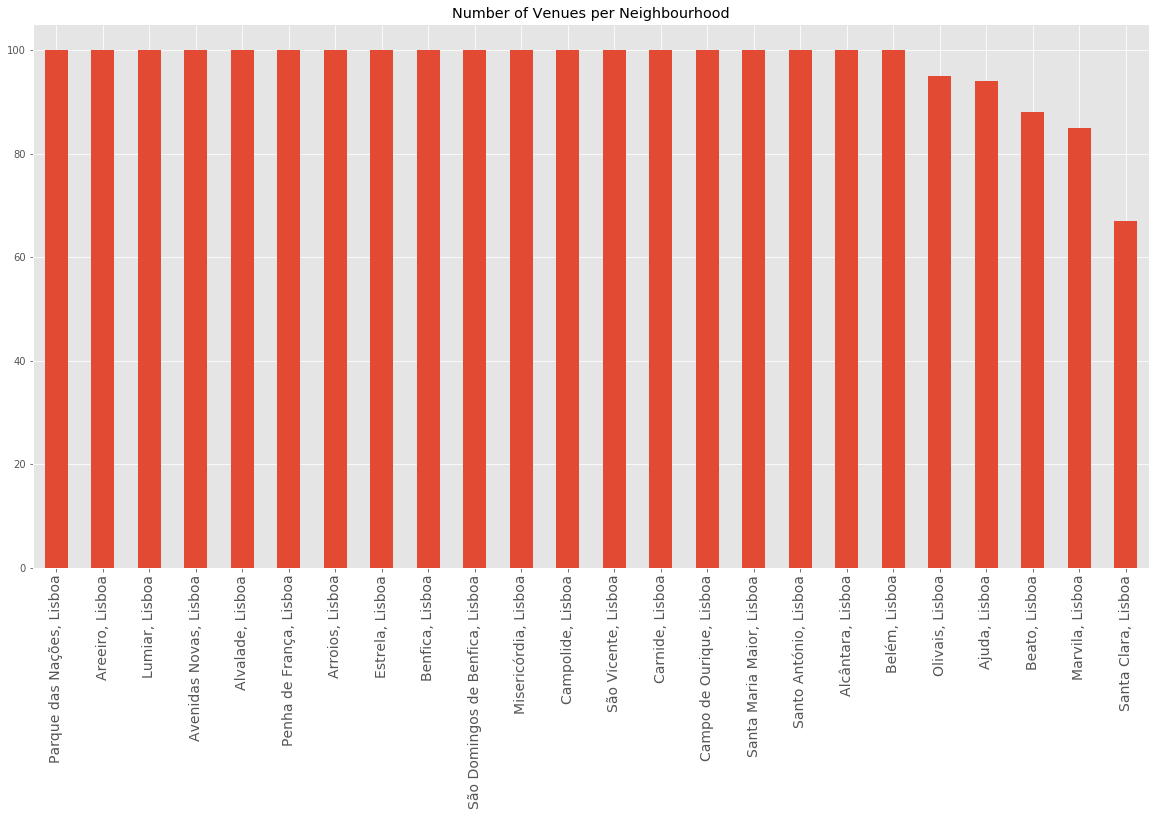

In [111]:
#Get how many venues were retrieved for each neighbourhood
counts=lisboa_venues['NOME'].value_counts()

#plot bar chart
ax = counts.plot.bar(rot=0,figsize=(20, 10))
plt.xticks(fontsize=14, rotation=90)
plt.title('Number of Venues per Neighbourhood')

Now, we will plot the venues to make a sense of what type of venues are more common:

Text(0.5, 1.0, 'Types of Venues')

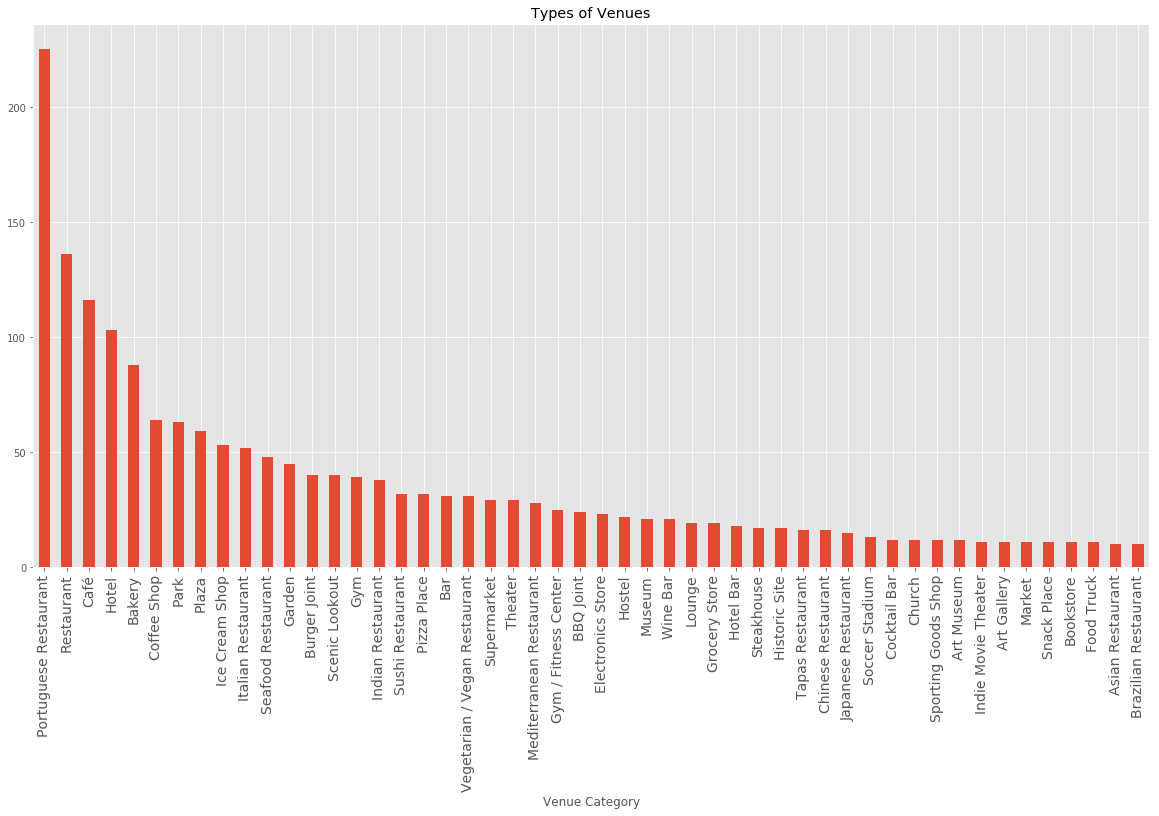

In [27]:
#Analysis of Venue Categories
venue_cat=lisboa_venues[['Venue Category']]

venue_cat=venue_cat.groupby(['Venue Category']).size().sort_values(ascending=False)

#plot bar chart
ax = venue_cat[:50].plot.bar(rot=0,figsize=(20, 10))
plt.xticks(fontsize=14, rotation=90)
plt.title('Types of Venues')

The top 4 venues in Lisbon are Restaurants, Cafés (coffee shops) and hotels, which clearly suggests that Lisbon truly is a very touristic city. We can learn from analyzing the graph that we have some categories that should be grouped. Doesn't make much sense separate restaurants from portuguese or italian restaurants, as an example. Also, cafés and coffee shops are the same thing.

Text(0.5, 1.0, 'Types of Venues')

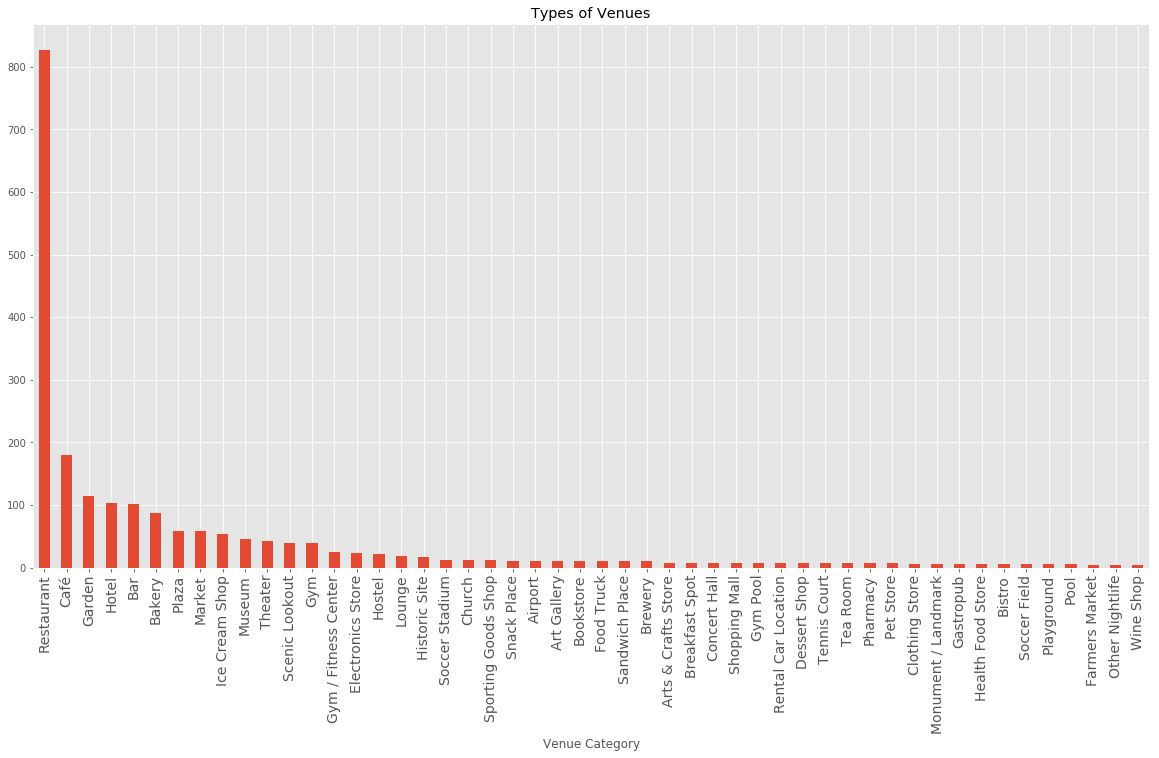

In [28]:


#group Venues
lisboa_venues.loc[lisboa_venues['Venue Category'].str.contains('Restaurant'), 'Venue Category'] = 'Restaurant'
lisboa_venues.loc[lisboa_venues['Venue Category'].str.contains('Steakhouse'), 'Venue Category'] = 'Restaurant'
lisboa_venues.loc[lisboa_venues['Venue Category'].str.contains('Pizza Place'), 'Venue Category'] = 'Restaurant'
lisboa_venues.loc[lisboa_venues['Venue Category'].str.contains('BBQ Joint'), 'Venue Category'] = 'Restaurant'
lisboa_venues.loc[lisboa_venues['Venue Category'].str.contains('Burger Joint'), 'Venue Category'] = 'Restaurant'
lisboa_venues.loc[lisboa_venues['Venue Category'].str.contains('Coffee Shop'), 'Venue Category'] = 'Café'
lisboa_venues.loc[lisboa_venues['Venue Category'].str.contains('Park'), 'Venue Category'] = 'Garden'
lisboa_venues.loc[lisboa_venues['Venue Category'].str.contains('Museum'), 'Venue Category'] = 'Museum'
lisboa_venues.loc[lisboa_venues['Venue Category'].str.contains('Bar'), 'Venue Category'] = 'Bar'
lisboa_venues.loc[lisboa_venues['Venue Category'].str.contains('Pub'), 'Venue Category'] = 'Bar'
lisboa_venues.loc[lisboa_venues['Venue Category'].str.contains('Beer Garden'), 'Venue Category'] = 'Bar'
lisboa_venues.loc[lisboa_venues['Venue Category'].str.contains('Airport'), 'Venue Category'] = 'Airport'
lisboa_venues.loc[lisboa_venues['Venue Category'].str.contains('Grocery Store'), 'Venue Category'] = 'Market'
lisboa_venues.loc[lisboa_venues['Venue Category'].str.contains('Supermarket'), 'Venue Category'] = 'Market'
lisboa_venues.loc[lisboa_venues['Venue Category'].str.contains('Theater'), 'Venue Category'] = 'Theater'

venue_cat=lisboa_venues[['Venue Category']]

venue_cat=venue_cat.groupby(['Venue Category']).size().sort_values(ascending=False)

#plot bar chart
ax = venue_cat[:50].plot.bar(rot=0,figsize=(20, 10))
plt.xticks(fontsize=14, rotation=90)
plt.title('Types of Venues')

#### 3.3 Frequency of Venues per Neighbourhood via one-hot encoding

Let's do one hot encoding, and group venues by neighbourhood calculating the frequency mean. After that, we'll list the 10 most common types of venue per neighbourhood.

In [29]:
# one hot encoding
lisboa_onehot = pd.get_dummies(lisboa_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
lisboa_onehot['NOME'] = lisboa_venues['NOME'] 

# move neighborhood column to the first column
fixed_columns = [lisboa_onehot.columns[-1]] + list(lisboa_onehot.columns[:-1])
lisboa_onehot = lisboa_onehot[fixed_columns]

#group neighbourhoods and use the mean of the frequency of occurrence of each category to understand which type of venue is more usual in each neighbourhood
lisboa_grouped = lisboa_onehot.groupby('NOME').mean().reset_index()
lisboa_grouped.head()


,NOME,Accessories Store,Airport,Aquarium,Art Gallery,Arts & Crafts Store,Athletics & Sports,Automotive Shop,Bagel Shop,Bakery,...,Theater,Toy / Game Store,Trail,Train Station,Veterinarian,Warehouse Store,Waterfront,Wine Shop,Wings Joint,Zoo
0,"Ajuda, Lisboa",0.0,0.0,0.0,0.00,0.00,0.010638,0.0,0.00,0.042553,...,0.021277,0.0,0.00,0.0,0.0,0.010638,0.0,0.0,0.00,0.0
1,"Alcântara, Lisboa",0.0,0.0,0.0,0.00,0.00,0.010000,0.0,0.00,0.050000,...,0.010000,0.0,0.01,0.0,0.0,0.000000,0.0,0.0,0.00,0.0
2,"Alvalade, Lisboa",0.0,0.0,0.0,0.01,0.00,0.000000,0.0,0.01,0.060000,...,0.010000,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.00,0.0
3,"Areeiro, Lisboa",0.0,0.0,0.0,0.01,0.00,0.000000,0.0,0.00,0.070000,...,0.020000,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.01,0.0
4,"Arroios, Lisboa",0.0,0.0,0.0,0.00,0.01,0.000000,0.0,0.00,0.030000,...,0.060000,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.00,0.0


In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['NOME']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['NOME'] = lisboa_grouped['NOME']

for ind in np.arange(lisboa_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(lisboa_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,NOME,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Ajuda, Lisboa",Restaurant,Garden,Café,Museum,Bakery,Gym,Market,Tennis Court,Theater,Ice Cream Shop
1,"Alcântara, Lisboa",Restaurant,Garden,Café,Bakery,Museum,Dessert Shop,Market,Bar,Hotel,Plaza
2,"Alvalade, Lisboa",Restaurant,Bakery,Bar,Gym / Fitness Center,Plaza,Soccer Stadium,Hotel,Ice Cream Shop,Museum,Bookstore
3,"Areeiro, Lisboa",Restaurant,Bakery,Hotel,Bar,Gym / Fitness Center,Garden,Plaza,Ice Cream Shop,Electronics Store,Café
4,"Arroios, Lisboa",Restaurant,Hotel,Bar,Café,Plaza,Theater,Scenic Lookout,Garden,Bakery,Hostel


### 4. Clustering neighbourhoods based on their typical venues

To accomplish the task of clustering the neighbourhoods, we will use a very common unsupervised technique of Machine Learning called K-Means, used for segmenting data based on its features. 

#### 4.1 Finding the right number of clusters

In this step we will use the Elbow Method to find out which number of clusters is the least error-prone, so that our results may be as close as possible to the truth.

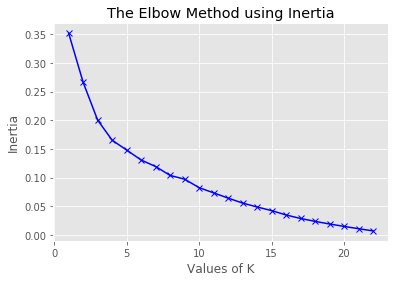

In [23]:
lisboa_grouped_clustering = lisboa_grouped.drop('NOME', 1)

#run K-Means to many values of number of clusters
Sum_of_squared_distances = []
K = range(1,23)
for k in K:
    km = KMeans(n_clusters=k, max_iter=1000)
    km = km.fit(lisboa_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

#plot to find out where is the elbow    
plt.plot(K, Sum_of_squared_distances, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

#### 4.2 Creating Clusters

Using the Elbow Method, we'll define the optimal number of clusters as 4.

In [32]:
# set number of clusters
kclusters = 4

lisboa_grouped_clustering = lisboa_grouped.drop('NOME', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(lisboa_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:]

array([0, 1, 1, 1, 2, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 3, 0, 1, 3, 2, 2,
       0, 2], dtype=int32)

#### 4.3 Merging data

In this step we will add the cluster labels to our initial Geodataframe achieved in section 2.

In [33]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

lisboa_merged = lisboa

# merge lisboa_grouped with lisboa_data to add latitude/longitude for each neighborhood
lisboa_merged = lisboa_merged.join(neighbourhoods_venues_sorted.set_index('NOME'), on='NOME')

lisboa_merged

,NOME,geometry,longitude,latitude,2016,2017,2018,2019,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Olivais, Lisboa","POLYGON ((-9.13429152930909 38.78491931477943,...",-9.125823,38.770324,1323,1444,1750,2263,3,Restaurant,Café,Airport,Bakery,Market,Rental Car Location,Hotel,Garden,Electronics Store,Farmers Market
1,"Marvila, Lisboa",POLYGON ((-9.125669319549052 38.76252241258399...,-9.112754,38.748259,1637,1692,1483,2786,1,Restaurant,Market,Ice Cream Shop,Motorcycle Shop,Art Gallery,Café,Electronics Store,Plaza,Gym / Fitness Center,Bakery
2,"Belém, Lisboa",POLYGON ((-9.205906694301216 38.71526233954682...,-9.209432,38.697769,1928,2288,2736,3426,0,Restaurant,Café,Museum,Garden,Bakery,Monument / Landmark,Ice Cream Shop,Market,Bar,Pool
3,"Campo de Ourique, Lisboa","POLYGON ((-9.157637159813509 38.7224577607051,...",-9.165223,38.718213,1957,2273,2965,3583,1,Restaurant,Hotel,Café,Garden,Bar,Ice Cream Shop,Gym,Plaza,Lounge,Museum
4,"Carnide, Lisboa",POLYGON ((-9.175215068103029 38.78026559915881...,-9.192649,38.759206,2050,2192,2572,3049,0,Restaurant,Café,Garden,Theater,Gym,Market,Pet Store,Electronics Store,Bakery,Ice Cream Shop
5,"Lumiar, Lisboa",POLYGON ((-9.166824071222393 38.78379256406318...,-9.163768,38.771330,1993,2057,2352,2591,0,Restaurant,Bakery,Café,Garden,Market,Museum,Gym,Plaza,Theater,Gym / Fitness Center
6,"Ajuda, Lisboa",POLYGON ((-9.193034175842961 38.71618525772601...,-9.201217,38.712186,1535,1847,2259,3085,0,Restaurant,Garden,Café,Museum,Bakery,Gym,Market,Tennis Court,Theater,Ice Cream Shop
7,"Alvalade, Lisboa",POLYGON ((-9.128572194846967 38.76301776793735...,-9.149140,38.753341,1979,2394,2957,3304,1,Restaurant,Bakery,Bar,Gym / Fitness Center,Plaza,Soccer Stadium,Hotel,Ice Cream Shop,Museum,Bookstore
8,"Areeiro, Lisboa","POLYGON ((-9.123735102113585 38.7386583701703,...",-9.132269,38.741910,1803,2193,2550,3019,1,Restaurant,Bakery,Hotel,Bar,Gym / Fitness Center,Garden,Plaza,Ice Cream Shop,Electronics Store,Café
9,"Santa Clara, Lisboa","POLYGON ((-9.148456633629667 38.7947383405732,...",-9.153361,38.786060,1518,1512,1739,2058,3,Restaurant,Café,Bakery,Market,Garden,Airport,Theater,Pharmacy,Museum,Food


#### 4.4 Cluster Analysis

In this step we will analyze the resulting clusters, and name them accordingly to their characteristics.

In [34]:
cluster1=lisboa_merged.loc[lisboa_merged['Cluster Labels'] == 0, lisboa_merged.columns[[0] + list(range(9, lisboa_merged.shape[1]))]]

cluster1

,NOME,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Belém, Lisboa",Restaurant,Café,Museum,Garden,Bakery,Monument / Landmark,Ice Cream Shop,Market,Bar,Pool
4,"Carnide, Lisboa",Restaurant,Café,Garden,Theater,Gym,Market,Pet Store,Electronics Store,Bakery,Ice Cream Shop
5,"Lumiar, Lisboa",Restaurant,Bakery,Café,Garden,Market,Museum,Gym,Plaza,Theater,Gym / Fitness Center
6,"Ajuda, Lisboa",Restaurant,Garden,Café,Museum,Bakery,Gym,Market,Tennis Court,Theater,Ice Cream Shop
11,"São Domingos de Benfica, Lisboa",Restaurant,Garden,Café,Gym,Hotel,Ice Cream Shop,Historic Site,Bakery,Electronics Store,Theater
13,"Parque das Nações, Lisboa",Restaurant,Café,Garden,Hotel,Market,Ice Cream Shop,Gym,Electronics Store,Lounge,Scenic Lookout
21,"Benfica, Lisboa",Restaurant,Café,Garden,Sporting Goods Shop,Gym,Ice Cream Shop,Market,Clothing Store,Pet Store,Theater


In [35]:
cluster2=lisboa_merged.loc[lisboa_merged['Cluster Labels'] == 1, lisboa_merged.columns[[0] + list(range(9, lisboa_merged.shape[1]))]]

cluster2

,NOME,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Marvila, Lisboa",Restaurant,Market,Ice Cream Shop,Motorcycle Shop,Art Gallery,Café,Electronics Store,Plaza,Gym / Fitness Center,Bakery
3,"Campo de Ourique, Lisboa",Restaurant,Hotel,Café,Garden,Bar,Ice Cream Shop,Gym,Plaza,Lounge,Museum
7,"Alvalade, Lisboa",Restaurant,Bakery,Bar,Gym / Fitness Center,Plaza,Soccer Stadium,Hotel,Ice Cream Shop,Museum,Bookstore
8,"Areeiro, Lisboa",Restaurant,Bakery,Hotel,Bar,Gym / Fitness Center,Garden,Plaza,Ice Cream Shop,Electronics Store,Café
10,"Alcântara, Lisboa",Restaurant,Garden,Café,Bakery,Museum,Dessert Shop,Market,Bar,Hotel,Plaza
12,"Beato, Lisboa",Restaurant,Café,Hotel,Market,Electronics Store,Scenic Lookout,Snack Place,Brewery,Gym / Fitness Center,Bakery
15,"Avenidas Novas, Lisboa",Restaurant,Hotel,Café,Bakery,Garden,Bar,Plaza,Museum,Gym,Art Gallery
16,"Estrela, Lisboa",Restaurant,Café,Ice Cream Shop,Lounge,Bar,Garden,Bakery,Deli / Bodega,Market,Museum
19,"Penha de França, Lisboa",Restaurant,Bar,Café,Scenic Lookout,Garden,Bakery,Plaza,Theater,Electronics Store,Arts & Crafts Store
20,"Misericórdia, Lisboa",Restaurant,Bar,Café,Plaza,Ice Cream Shop,Lounge,Hostel,Garden,Food Court,Art Gallery


In [36]:
cluster3=lisboa_merged.loc[lisboa_merged['Cluster Labels'] == 2, lisboa_merged.columns[[0] + list(range(9, lisboa_merged.shape[1]))]]

cluster3

,NOME,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,"São Vicente, Lisboa",Restaurant,Café,Bar,Hotel,Scenic Lookout,Plaza,Bakery,Ice Cream Shop,Church,Hostel
17,"Santa Maria Maior, Lisboa",Restaurant,Hotel,Café,Plaza,Bar,Hostel,Ice Cream Shop,Scenic Lookout,Theater,Church
18,"Santo António, Lisboa",Restaurant,Bar,Hotel,Garden,Plaza,Café,Ice Cream Shop,Theater,Hostel,Lounge
22,"Arroios, Lisboa",Restaurant,Hotel,Bar,Café,Plaza,Theater,Scenic Lookout,Garden,Bakery,Hostel


In [37]:
cluster4=lisboa_merged.loc[lisboa_merged['Cluster Labels'] == 3, lisboa_merged.columns[[0] + list(range(9, lisboa_merged.shape[1]))]]

cluster4

,NOME,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Olivais, Lisboa",Restaurant,Café,Airport,Bakery,Market,Rental Car Location,Hotel,Garden,Electronics Store,Farmers Market
9,"Santa Clara, Lisboa",Restaurant,Café,Bakery,Market,Garden,Airport,Theater,Pharmacy,Museum,Food


Looking at the resulting clusters we can now label them:

* Cluster 1 - Gardens and Cafés

* Cluster 2 - High diversity of venues

* Cluster 3 - Accomodation and Social Areas

* Cluster 4 - Residential area, low offer of services


#### 4.5 Setting Labels

In this step we will change the Cluster Labels accordingly to their characteristics to identify the area.
We will also create new labels to identify the neighbourhoods accordingly to its average housing price.

In [38]:
lisboa_merged['Cluster Label']=lisboa_merged['Cluster Labels']

lisboa_merged=lisboa_merged.replace({'Cluster Label':{0: 'Social Areas, Gardens and Cafés', 1: 'Business Areas, high diversity of venues', 2: 'Touristic Areas, Accomodation and Bars', 3: 'Residential area, low offer of services'}})
lisboa_merged.head()

,NOME,geometry,longitude,latitude,2016,2017,2018,2019,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Label
0,"Olivais, Lisboa","POLYGON ((-9.13429152930909 38.78491931477943,...",-9.125823,38.770324,1323,1444,1750,2263,3,Restaurant,Café,Airport,Bakery,Market,Rental Car Location,Hotel,Garden,Electronics Store,Farmers Market,"Residential area, low offer of services"
1,"Marvila, Lisboa",POLYGON ((-9.125669319549052 38.76252241258399...,-9.112754,38.748259,1637,1692,1483,2786,1,Restaurant,Market,Ice Cream Shop,Motorcycle Shop,Art Gallery,Café,Electronics Store,Plaza,Gym / Fitness Center,Bakery,"Business Areas, high diversity of venues"
2,"Belém, Lisboa",POLYGON ((-9.205906694301216 38.71526233954682...,-9.209432,38.697769,1928,2288,2736,3426,0,Restaurant,Café,Museum,Garden,Bakery,Monument / Landmark,Ice Cream Shop,Market,Bar,Pool,"Social Areas, Gardens and Cafés"
3,"Campo de Ourique, Lisboa","POLYGON ((-9.157637159813509 38.7224577607051,...",-9.165223,38.718213,1957,2273,2965,3583,1,Restaurant,Hotel,Café,Garden,Bar,Ice Cream Shop,Gym,Plaza,Lounge,Museum,"Business Areas, high diversity of venues"
4,"Carnide, Lisboa",POLYGON ((-9.175215068103029 38.78026559915881...,-9.192649,38.759206,2050,2192,2572,3049,0,Restaurant,Café,Garden,Theater,Gym,Market,Pet Store,Electronics Store,Bakery,Ice Cream Shop,"Social Areas, Gardens and Cafés"


Let's also label the neighbourhoods by Housing Price. First, we'll plot it on an histogram with 4 bins, to match the number of clusters:



Text(0.5, 1.0, 'Distribution of Housing Price')

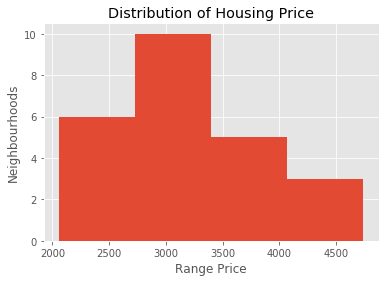

In [130]:
plt.hist(lisboa_merged['2019'], bins=4)
plt.xlabel('Range Price') 
plt.ylabel('Neighbourhoods') 
plt.title('Distribution of Housing Price') 

The labels will be:

* 2058 - 2729: Low Price Areas 
* 2729 - 3400: Low-to-Mid Price Areas 
* 3400 - 4071: Mid-to-High Price Areas
* 4071 - 4742: High Price Areas

In [39]:
lisboa_merged['Housing Price Label'] = pd.cut(lisboa_merged['2019'], [2058, 2729, 3400,4071,4742], labels=['Low Housing Price Areas', 'Low-to-Mid Housing Price Areas ', 'Mid-to-High Housing Price Areas', 'High Housing Price Areas'])
lisboa_merged.head()

,NOME,geometry,longitude,latitude,2016,2017,2018,2019,Cluster Labels,1st Most Common Venue,...,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Label,Housing Price Label
0,"Olivais, Lisboa","POLYGON ((-9.13429152930909 38.78491931477943,...",-9.125823,38.770324,1323,1444,1750,2263,3,Restaurant,...,Airport,Bakery,Market,Rental Car Location,Hotel,Garden,Electronics Store,Farmers Market,"Residential area, low offer of services",Low Housing Price Areas
1,"Marvila, Lisboa",POLYGON ((-9.125669319549052 38.76252241258399...,-9.112754,38.748259,1637,1692,1483,2786,1,Restaurant,...,Ice Cream Shop,Motorcycle Shop,Art Gallery,Café,Electronics Store,Plaza,Gym / Fitness Center,Bakery,"Business Areas, high diversity of venues",Low-to-Mid Housing Price Areas
2,"Belém, Lisboa",POLYGON ((-9.205906694301216 38.71526233954682...,-9.209432,38.697769,1928,2288,2736,3426,0,Restaurant,...,Museum,Garden,Bakery,Monument / Landmark,Ice Cream Shop,Market,Bar,Pool,"Social Areas, Gardens and Cafés",Mid-to-High Housing Price Areas
3,"Campo de Ourique, Lisboa","POLYGON ((-9.157637159813509 38.7224577607051,...",-9.165223,38.718213,1957,2273,2965,3583,1,Restaurant,...,Café,Garden,Bar,Ice Cream Shop,Gym,Plaza,Lounge,Museum,"Business Areas, high diversity of venues",Mid-to-High Housing Price Areas
4,"Carnide, Lisboa",POLYGON ((-9.175215068103029 38.78026559915881...,-9.192649,38.759206,2050,2192,2572,3049,0,Restaurant,...,Garden,Theater,Gym,Market,Pet Store,Electronics Store,Bakery,Ice Cream Shop,"Social Areas, Gardens and Cafés",Low-to-Mid Housing Price Areas


### 5. Results

Now that we have a consolidated dataframe with all the necessary information, we will plot all of this data.

We'll first draw a choropleth map identifying the neighbourhoods by its average housing price. We will then superimpose markers identifying the cluster. 
The label will show us the name of the area, the type of neighbourhood and the class of housing prices of that neighbourhood.

In [40]:
# create map
Lisboa_Coord=geolocator.geocode('Lisboa')
Longitude = Lisboa_Coord.longitude
Latitude = Lisboa_Coord.latitude

map_clusters = folium.Map(location=[Latitude, Longitude], zoom_start=11,)

map_clusters.choropleth(
    geo_data=lisboa_merged,
    data=lisboa_merged,
    columns=['NOME', '2019'],
    key_on='feature.properties.NOME',
    bins=4,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name = 'House Prices in Lisbon'
    )


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, nome, cluster, housing, label in zip(lisboa_merged['latitude'], lisboa_merged['longitude'], lisboa_merged['NOME'], lisboa_merged['Cluster Labels'], lisboa_merged['Housing Price Label'],lisboa_merged['Cluster Label']):
    label = folium.Popup(str(nome) + '; ' + str(label) + '; ' +str(housing), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

/opt/conda/envs/Python36/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### 6. Discussion

Looking at the map, it's clear that the housing price doesn't really play a role in determining the type of existing venues in an neighbourhood. The opposite is also true, with the existing venues not influencing the the house prices. 

Addressing the segmentation,  we can see some logic on how it happened, being circular around downtown Lisbon (the light blue cluster). 

The light blue cluster corresponds to the touristic area, which falls on the oldest part of the city and therefore, has more touristic interest. It's also an area that has a lot of restaurants, hotels and nightlife.
The purple cluster corresponds to the business area, and it's located around downtown. This is where we can find many businesses, and that's why we can find such a high diversity of venues in this cluster.
The red cluster corresponds to business/residential hybrid area, with a lot of parks and cafés to drink coffee, a cold drink ou just spend some time during the day.
The light green cluster corresponds to residential areas, with a reduced number of venues, since these areas provide mainly housing.

Addressing the housing prices, we can't really see a geographical coorrelation between price and location (like proximity to the city center). Although the historical center of the city is the most expensive area of the city, the prices are not evenly distributed around these areas. This can be explained by the fact that some neighbourhoods are, by tradition, more fancy and with richer households. These neighbourhoods are usually called "classic neighbourhoods" in Lisbon. This explains why Belém, São Vicente, Estrela and Campo de Ourique appear in the Mid-to-High Housing Price range. Avenidas Novas is one of the most modern neighbourhoods in the city, and that's why it also belongs to this class.

### 7. Conclusions and Next Steps

Lisbon is a very popular city right now, as we could confirm by the analysis of the growth in housing prices in the city. This study can be helpful to anyone interested in moving into the city to work or start a business. We could also see that Lisbon has a very high quantity of restaurant venues, showing how gastronomy is such a import part of the Portuguese identity. This study might also be useful for any city planner that wishes to observe how the city is developing, either in price and in type of services. We can see that distance to the city center doesn't play a big role in housing price, and that we can find similar neighbourhoods with different ranges of housing prices, which may help people that are on a tighter budget, with minimal loss of quality of life.

The suggested next steps would be trying to relate public transportation services, which is probably a big player in housing prices. Areas with a lot of public transportation are usually more expensive. We could also explore the evolution of the city, applying this study to the data of previous years (we only used 2019 data, but we have data available since 2016).